# Loading the preprocessed data

In [1]:
import os
from pathlib import Path
import pandas as pd

DirPpath = Path(os.path.abspath('')).parent # Fetching the current directory path - Specific for ipynb file - For .py: Path(os.path.dirname(os.path.realpath(__file__)).replace("\\", "/"))


LDAPath  = str(DirPpath.absolute()) + "\PreProcessedData.csv"  
Lda = pd.read_csv(LDAPath, index_col=0)

Lda.head()

,Topic,Pledge,PreProcessedText
0,1,HOTREC calls for a level playing field and fai...,hotrec call level play field fair competition ...
1,1,Actually we as an association are still pretty...,actually association still pretty much begin d...
2,1,Estonia sees the need to synchronize and harmo...,estonia see need synchronize harmonize rule sh...
3,2,Achieve sustainable and flexible solutions for...,achieve sustainable flexible solution multimod...
5,3,The Austrian Hoteliers Association (ÖHV) publi...,austrian hotelier association öhv publishes st...


# Finding Optimal number of topics

In [2]:
import nltk
# LDA has to be applied on tokenized vectors
tokens = [nltk.word_tokenize(i) for i in Lda["PreProcessedText"]]

import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(tokens)
# Create Corpus
texts = tokens
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 3), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 5), (24, 2), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1)]


In [5]:
import gensim
from gensim.models.coherencemodel import CoherenceModel

LDA = gensim.models.ldamodel.LdaModel

results = []

for t in range(2, 30):
    lda_model = LDA(corpus=corpus, id2word=id2word, num_topics=t, random_state=100,
                chunksize=200, passes=100)
    corpus_lda = lda_model[corpus]

    cm = CoherenceModel( model=lda_model,texts=tokens, dictionary=id2word, coherence='c_v')
    score = cm.get_coherence()
    tup = t, score
    results.append(tup)

results = pd.DataFrame(results, columns=['topic', 'score'])


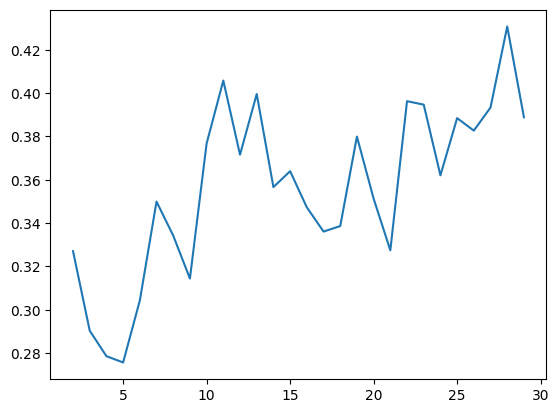

In [6]:
s = pd.Series(results.score.values, index=results.topic.values)
_ = s.plot()

# Building model (26 topics)

In [3]:
import gensim
from pprint import pprint
# number of topics
num_topics = 5
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.030*"tourism" + 0.010*"sustainable" + 0.008*"destination" + '
  '0.007*"project" + 0.006*"development" + 0.006*"sector" + 0.006*"support" + '
  '0.005*"green" + 0.005*"sustainability" + 0.005*"city"'),
 (1,
  '0.037*"tourism" + 0.010*"sustainable" + 0.008*"sustainability" + '
  '0.007*"project" + 0.007*"data" + 0.006*"development" + 0.006*"work" + '
  '0.006*"destination" + 0.005*"support" + 0.005*"eu"'),
 (2,
  '0.022*"tourism" + 0.010*"sustainable" + 0.009*"development" + '
  '0.007*"tourist" + 0.006*"project" + 0.006*"destination" + 0.006*"city" + '
  '0.006*"support" + 0.006*"information" + 0.005*"digital"'),
 (3,
  '0.024*"tourism" + 0.009*"destination" + 0.008*"data" + 0.008*"sustainable" '
  '+ 0.006*"support" + 0.006*"develop" + 0.005*"tourist" + 0.005*"development" '
  '+ 0.005*"use" + 0.004*"digital"'),
 (4,
  '0.037*"tourism" + 0.009*"data" + 0.009*"destination" + 0.007*"sector" + '
  '0.007*"support" + 0.006*"tourist" + 0.006*"year" + 0.005*"development" + '
  '0.

In [16]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=Lda["PreProcessedText"]):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=tokens)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

df_dominant_topic["Topic"] = Lda["Topic"]


Path = str(DirPpath.absolute()) + "\LDATopics.xlsx"
df_dominant_topic.to_excel(Path)

<>:36: DeprecationWarning: invalid escape sequence \L
<>:36: DeprecationWarning: invalid escape sequence \L
C:\Users\ecaudron001\AppData\Local\Temp\ipykernel_18708\3614537058.py:36: DeprecationWarning: invalid escape sequence \L
  Path = str(DirPpath.absolute()) + "\LDATopics.xlsx"
C:\Users\ecaudron001\AppData\Local\Temp\ipykernel_18708\3614537058.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\ecaudron001\AppData\Local\Temp\ipykernel_18708\3614537058.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\ecaudron001\AppData\Local\Temp\ipykernel_1

# Visualizing the topics

In [4]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(topic_model = lda_model, corpus = corpus, dictionary = id2word) # mds = 'tsne'
panel

c:\Users\ecaudron001\Documents\GitHub\semic_pledges\.venv\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.010374  0.013399       1        1  29.685260
4      0.020497 -0.011021       2        1  22.814254
2     -0.022684 -0.009283       3        1  19.991769
0     -0.008070  0.015448       4        1  18.045775
3     -0.000116 -0.008543       5        1   9.462941, topic_info=               Term        Freq       Total Category  logprob  loglift
17             data  133.000000  133.000000  Default  30.0000  30.0000
159         tourism  705.000000  705.000000  Default  29.0000  29.0000
266     destination  159.000000  159.000000  Default  28.0000  28.0000
155     sustainable  198.000000  198.000000  Default  27.0000  27.0000
306         tourist  108.000000  108.000000  Default  26.0000  26.0000
..              ...         ...         ...      ...      ...      ...
442  sustainability    7.884830  132.143588   Topic5  -5.5987  -0.4612
426            plan    6.440585   79.337387   Topic5  -5.8010  -0.1533
81            share    6.271012   70.858033   Topic5  -5.8277  -0.0670
23               eu    6.480210   94.819631   Topic5  -5.7949  -0.3254
307          travel    6.288268   74.867964   Topic5  -5.8249  -0.1193

[427 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
847       1  0.238279  accessibility
847       2  0.198566  accessibility
847       3  0.357419  accessibility
847       4  0.119140  accessibility
847       5  0.079426  accessibility
...     ...       ...            ...
2737      4  0.604687           zoom
228       1  0.148414            öhv
228       2  0.593655            öhv
228       3  0.148414            öhv
228       5  0.148414            öhv

[901 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 3, 1, 4])